In [ ]:
pip install yfinance

In [ ]:
pip install statsmodels

In [ ]:
pip install mplfinance

In [ ]:
pip install pmdarima

In [ ]:
import yfinance as yf
import mplfinance as mpf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline

In [ ]:
apple = "AAPL"
stock_data = yf.Ticker(apple)
stock_data_hist = stock_data.history(start="2011-01-02", end="2022-12-31")
stock_data_test = stock_data.history(start = "2022-12-31", end = "2023-12-31")
data = pd.DataFrame(stock_data_hist[['Open', 'Close']])
print(type(data.index))
data_test = pd.DataFrame(stock_data_test[['Open', 'Close']])
data

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Open,Close
Date,,
2011-01-03 00:00:00-05:00,9.845952,9.964778
2011-01-04 00:00:00-05:00,10.051553,10.016783
2011-01-05 00:00:00-05:00,9.964175,10.098723
2011-01-06 00:00:00-05:00,10.120491,10.090558
2011-01-07 00:00:00-05:00,10.098419,10.162821
...,...,...
2022-12-23 00:00:00-05:00,130.026375,130.959961
2022-12-27 00:00:00-05:00,130.483247,129.142456
2022-12-28 00:00:00-05:00,128.784900,125.179680


In [ ]:
#applying tsa stats tool to check whether there is the prices are stationary or not

def stationary(okk):
  results = adfuller(okk)
  return results[1]

In [ ]:
#lets verify our prices are stationary or not( which is not generally)
#adfuller - null hypothesis(non- stationary) so p-value < 0.05 -> stationary

print(f"P-value of Open prices are : {stationary(data['Open'])}")

P-value of Open prices are : 0.9335907540591903


In [ ]:
#clearly its quite >>0.05 or 5% so we check if difference of these prices are stationary or not

data['First_Difference'] =(data['Open'].diff())
data.dropna(inplace = True)
print(f"P-value of First difference prices are : {stationary(data['First_Difference'])}")

P-value of First difference prices are : 4.755932873210904e-19


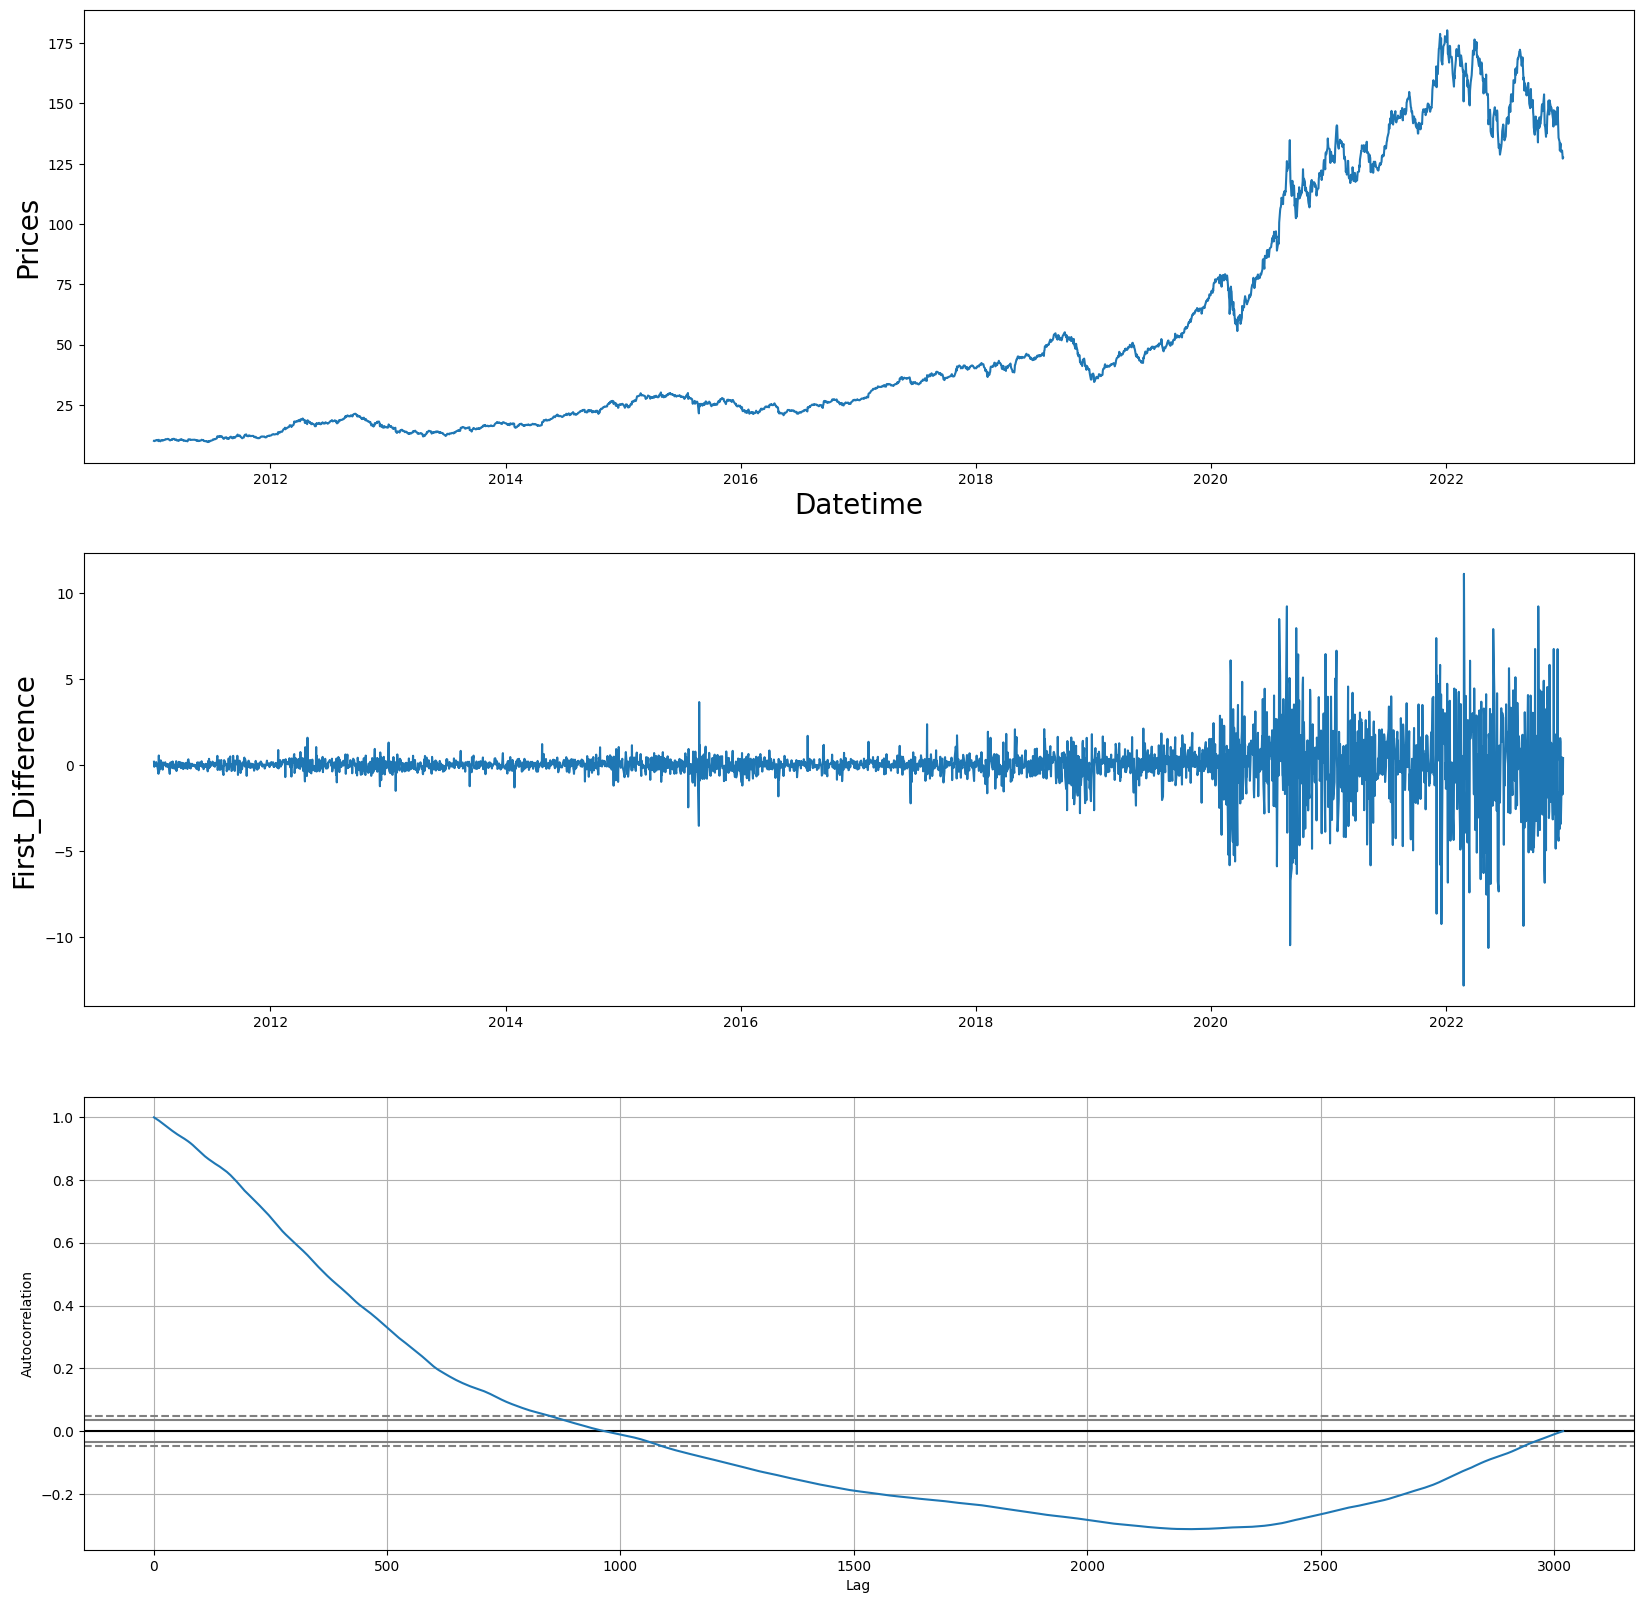

In [ ]:
fig,ax = plt.subplots(figsize = (20,20), nrows = 3)
ax[0].plot(data.index, data['Open'])
ax[0].set_xlabel("Datetime", fontsize = 20)
ax[0].set_ylabel("Prices",fontsize = 20)
ax[1].plot(data.index, data['First_Difference'])
ax[1].set_ylabel("First_Difference",fontsize = 20)
autocorrelation_plot(data['Open'], ax = ax[2])
plt.show()

P-value of Second difference prices are : 4.805321848633898e-19


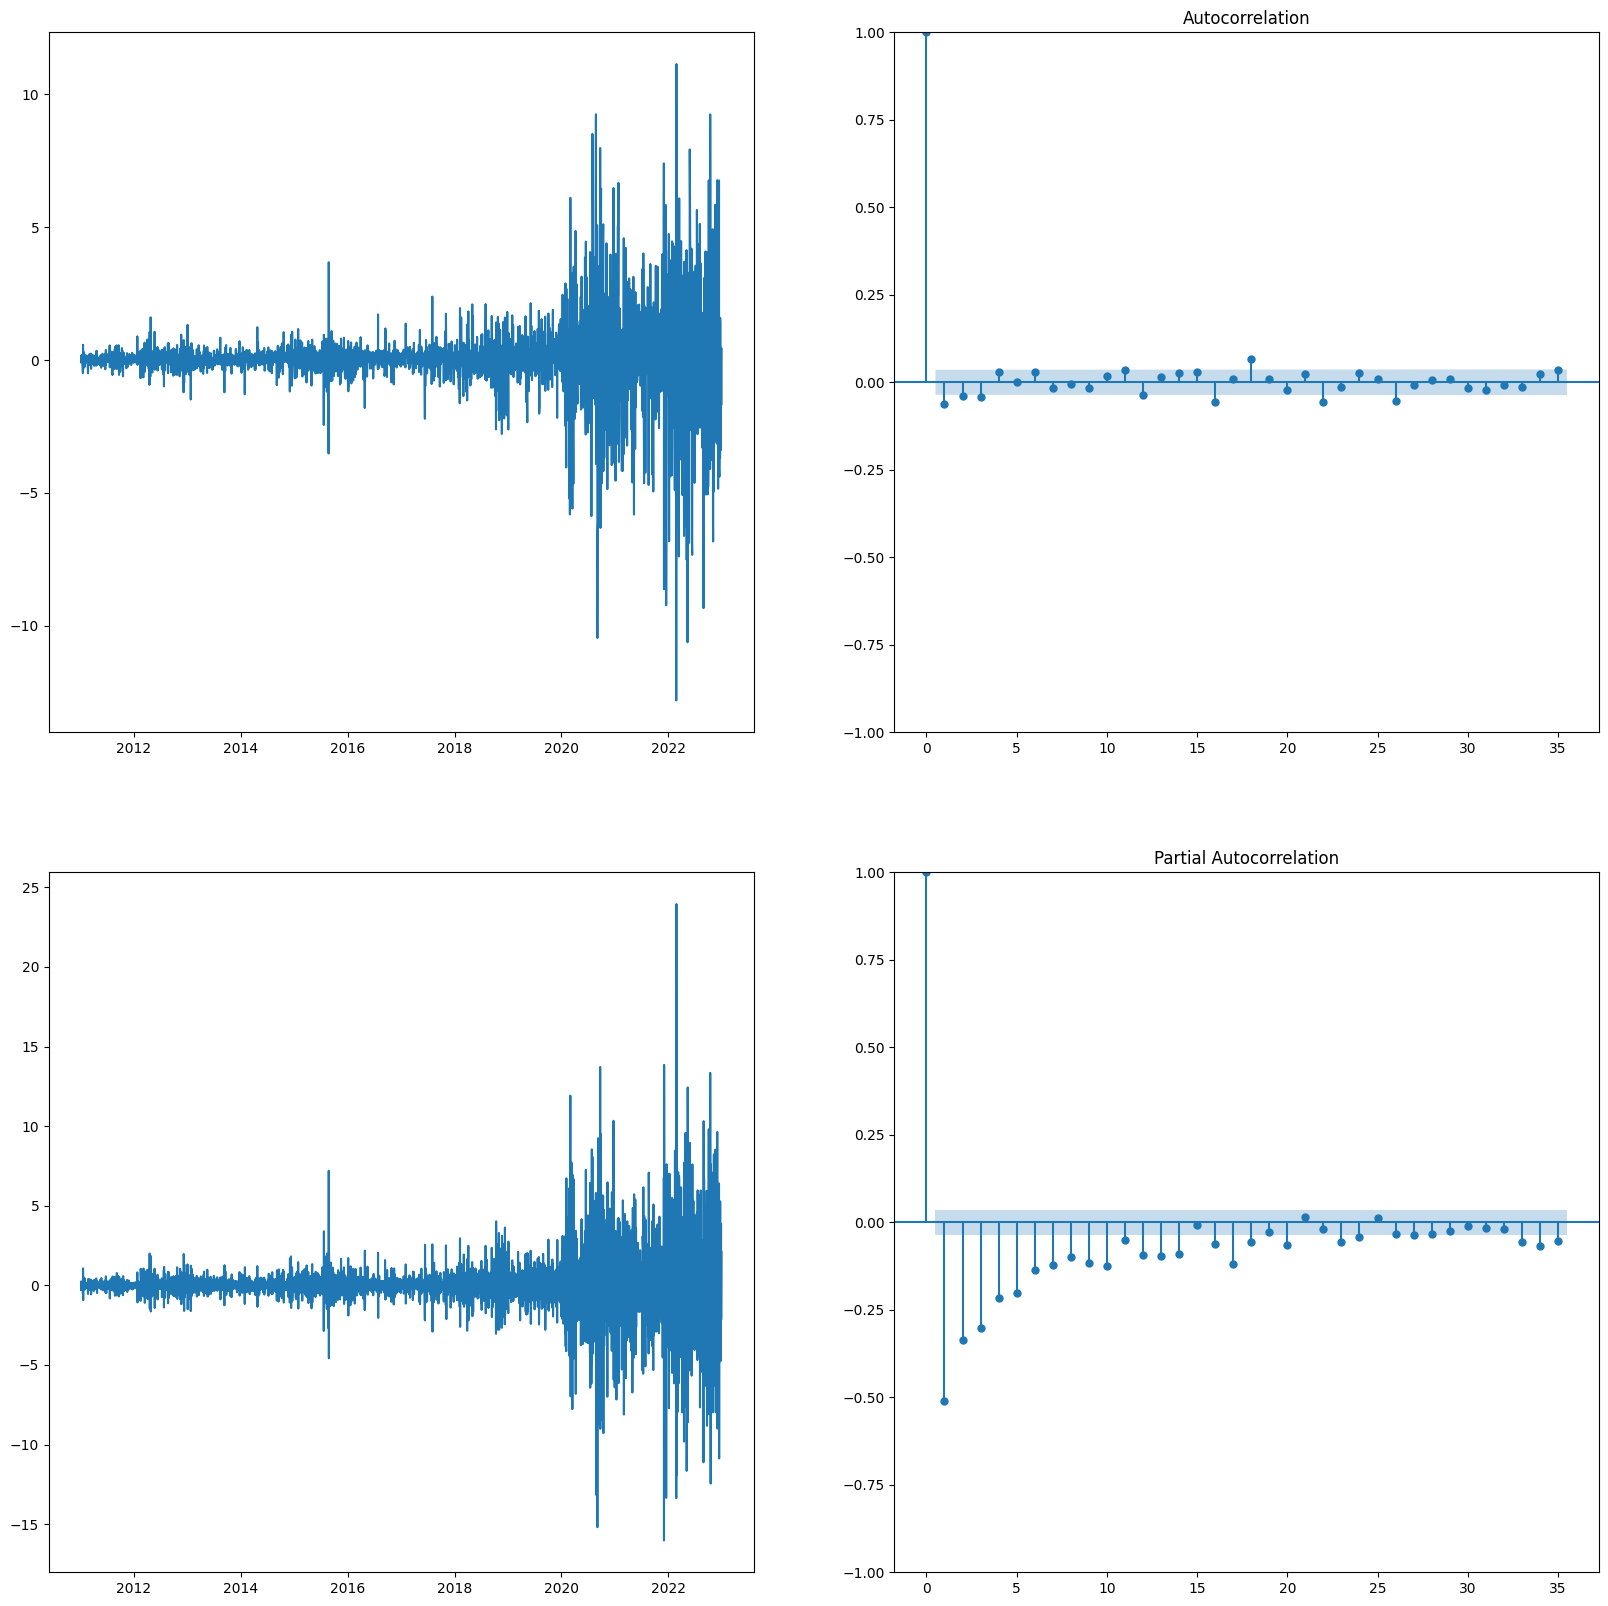

In [ ]:
data['Second_Difference'] = data['First_Difference'].diff()
data.dropna(inplace = True)
print(f"P-value of Second difference prices are : {stationary(data['First_Difference'])}")
fig,ax = plt.subplots(figsize = (20,20), nrows = 2, ncols = 2)
ax[0][0].plot(data.index, data['First_Difference'])
plot_acf(data['First_Difference'],ax = ax[0][1])
ax[1][0].plot(data.index, data['Second_Difference'])
plot_pacf(data['Second_Difference'],ax = ax[1][1])
plt.show()

In [ ]:
#as we difference it more we can see autocorrelation factor increases for lag> 2 so we can conclude that diffrencing of 1 is enough
#to make data stationary i.e d = 1 (d = diffrencing parameter in ARIMA Model)

#we can directly find this optimal value by using ndiffs of library pmdarima

d_value = ndiffs(data['Open'], test = 'adf')
print(d_value)

1


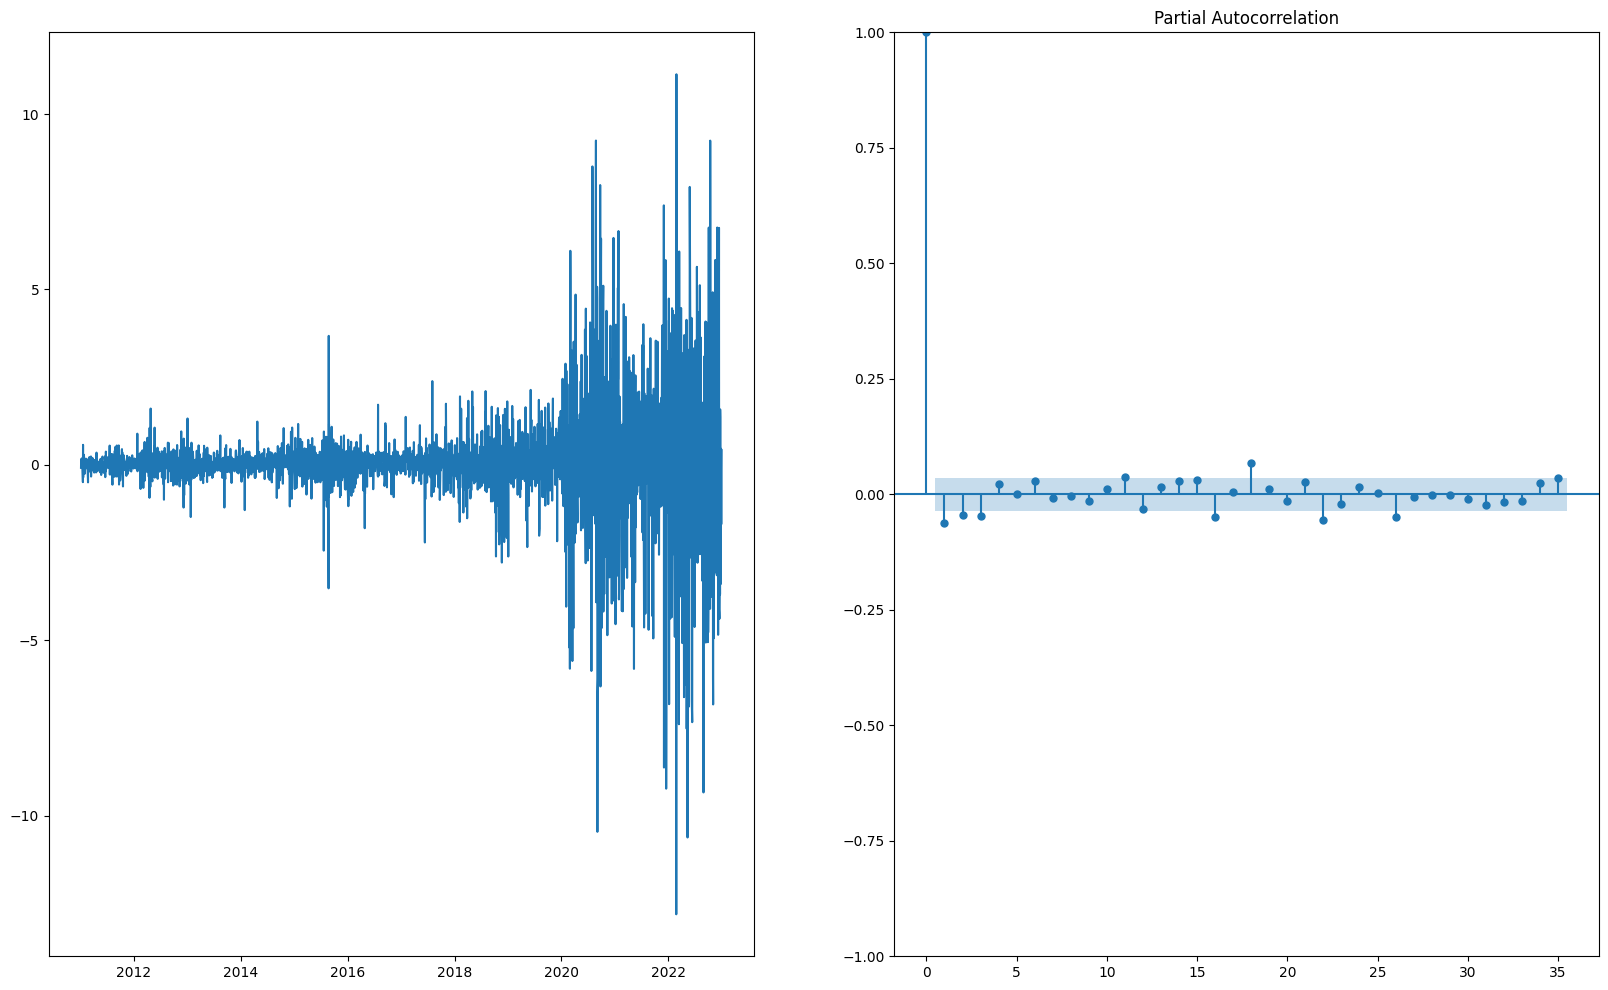

In [ ]:
# next is finding p - parameters in ARIMA Model i.e finding no. of lag terms to be used in AR Model
#using pacf we can identify what number of lags features are dependent on target value whch are independent of each other thats why partial acf

fig,ax = plt.subplots(figsize = (20,12),ncols = 2)
ax[0].plot(data.index, data['First_Difference'])
plot_pacf(data['First_Difference'], ax = ax[1])
plt.show()

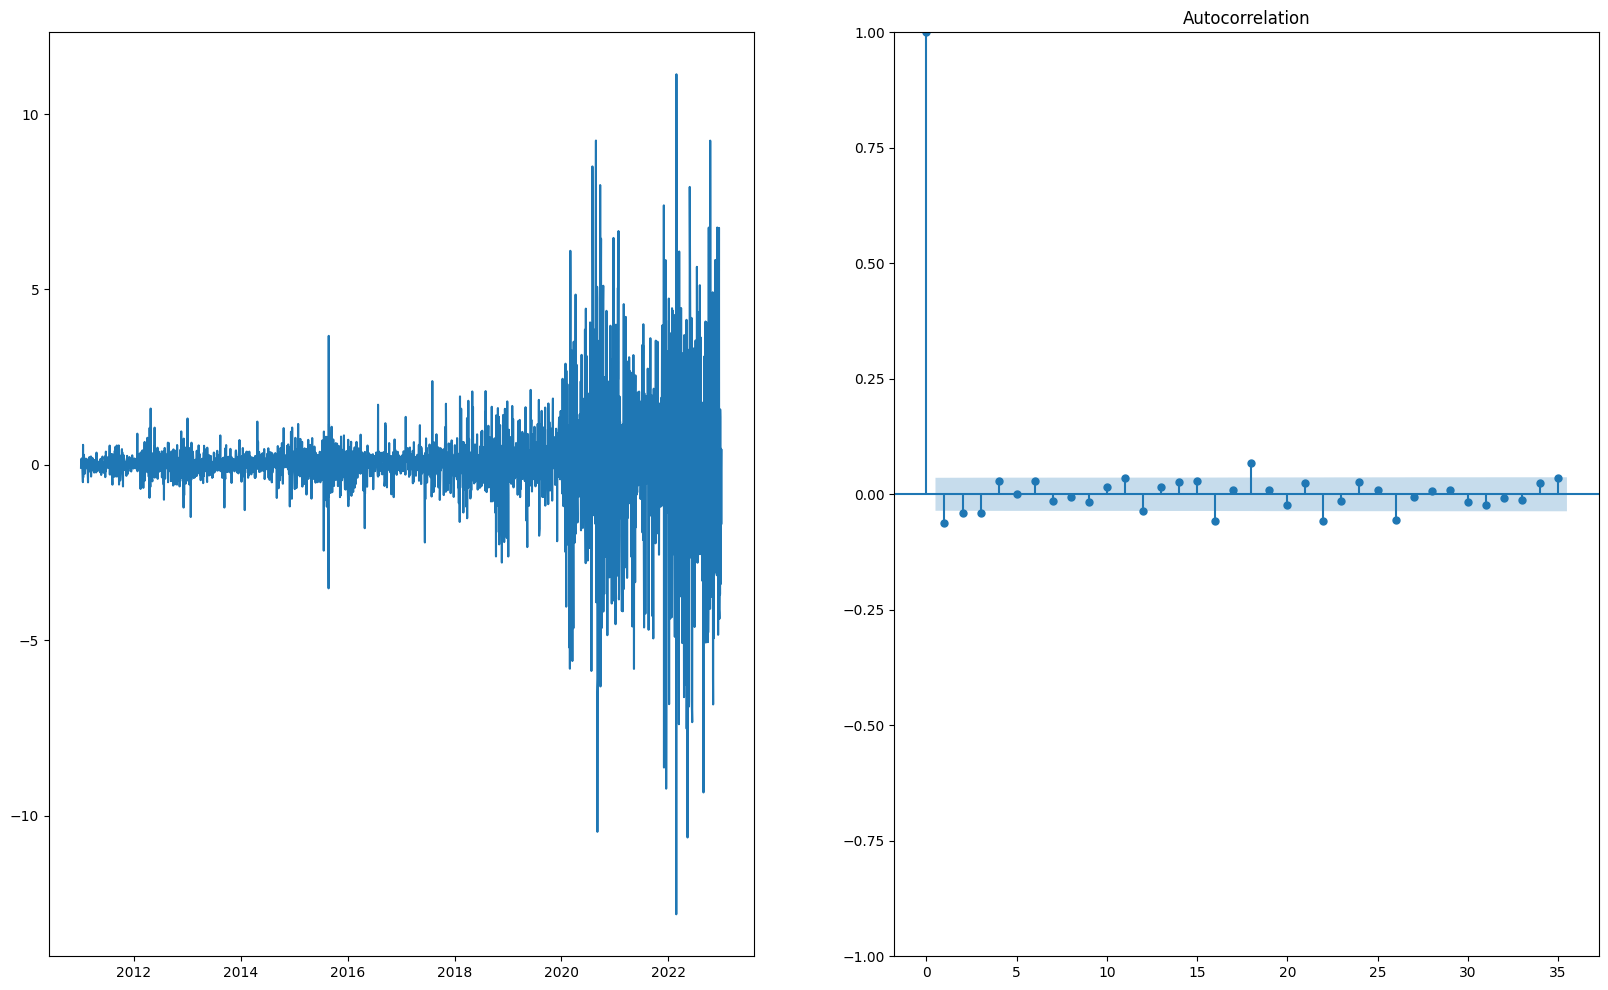

In [ ]:
#here we can observe that lags 1,2,3,4 specially 1 are greatly above the significance line
#so we can take p = 4

#lets find last parameters of ARIMA Model i.e q term = no. of errors lags to be used in MA model
#using acf_model we can see how many lags affect that target so corresponsding lags are responsible for ot


fig,ax = plt.subplots(figsize = (20,12),ncols = 2)
ax[0].plot(data.index, data['First_Difference'])
plot_acf(data['First_Difference'], ax = ax[1])
plt.show()

In [ ]:
#here also we can observe that lags 1,2,3,4 specially 1 are greatly above the significance line
#so we can take q = 4

#finally fit arima model on data
model = ARIMA(data['Open'], order = (1,4,4))
result = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 3018
Model:                 ARIMA(1, 4, 4)   Log Likelihood               -5489.543
Date:                Sat, 09 Mar 2024   AIC                          10991.086
Time:                        16:50:21   BIC                          11027.152
Sample:                             0   HQIC                         11004.056
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.001   -844.992      0.000      -1.002      -0.998
ma.L1         -1.9908      0.004   -526.950      0.000      -1.998      -1.983
ma.L2         -0.0089      0.008     -1.052      0.2

(array([2.56564783e-04, 2.56564783e-04, 1.02625913e-03, 5.64442523e-03,
        1.44959103e-02, 3.14676707e-01, 3.98958238e-02, 8.72320263e-03,
        1.66767109e-03, 5.13129566e-04]),
 array([-14.79002619, -12.20708977,  -9.62415335,  -7.04121692,
         -4.4582805 ,  -1.87534408,   0.70759235,   3.29052877,
          5.8734652 ,   8.45640162,  11.03933804]),
 <BarContainer object of 10 artists>)

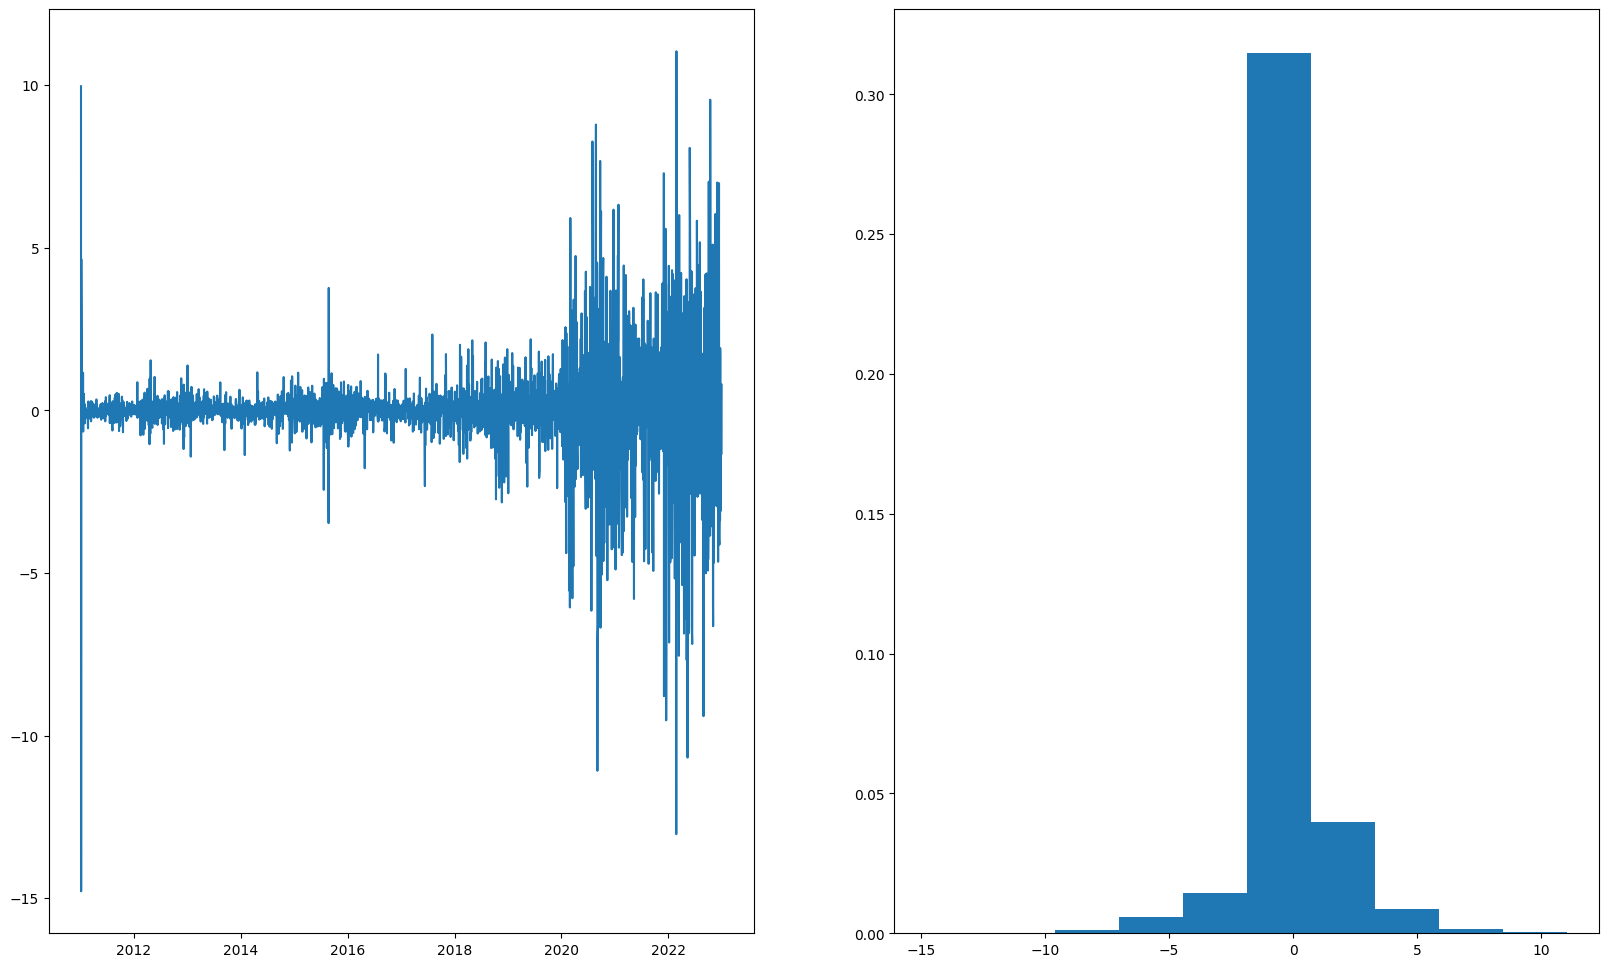

In [ ]:
#plotting residual errors

residuals = result.resid
fig,ax = plt.subplots(figsize = (20,12),ncols = 2)
ax[0].plot(residuals.index, residuals)
ax[1].hist(residuals, density = True)

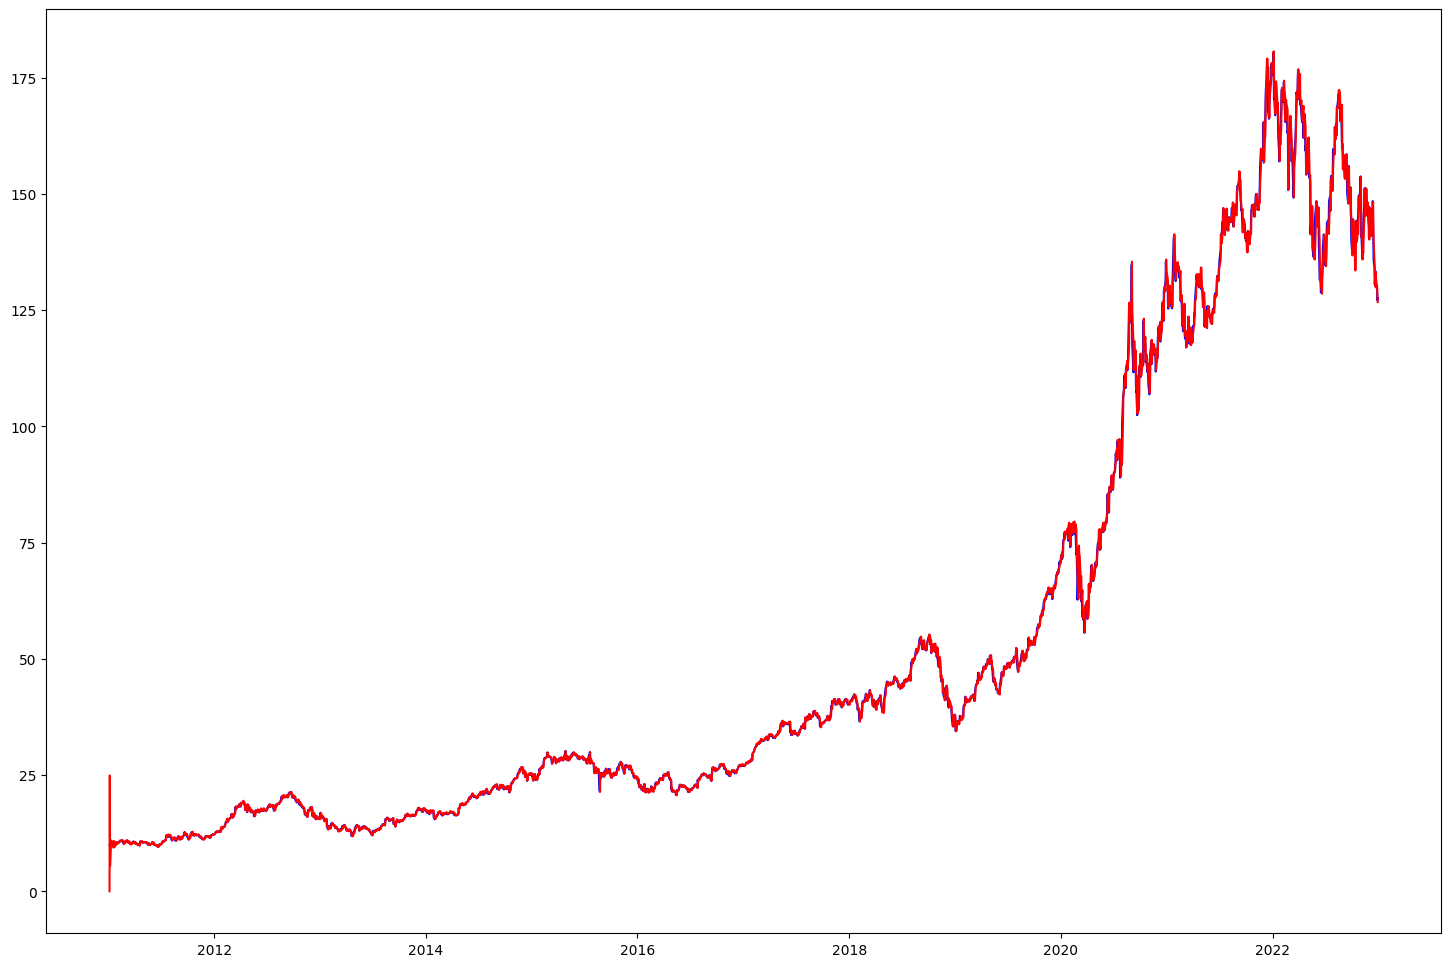

In [ ]:
# thus the forcasted model by ARIMA is stationary in nature and looks similar to first difference data
# to confirm this lets plot

fig = plt.subplots(figsize = (18,12))
plt.plot(data.index,data['Open'], color = 'blue')
plt.plot(result.predict().index, result.predict(), color = 'red')
plt.show()

In [ ]:
#getting forecast bundled result from fitted model
step = 8
forecasts = result.get_forecast(step)

# getting the net predicted mean value (not actual value but predicted to be in its predicted range)
predicted_values = forecasts.predicted_mean

# Accessing confidence intervals or bounds of predicted range
confidence_intervals = forecasts.conf_int()

#displaying the outputs
forecasting = pd.Series(predicted_values.values, index = data_test.index[:step])
lower = pd.Series(confidence_intervals['lower Open'].values, index = data_test.index[:step])
upper = pd.Series(confidence_intervals['upper Open'].values, index = data_test.index[:step])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


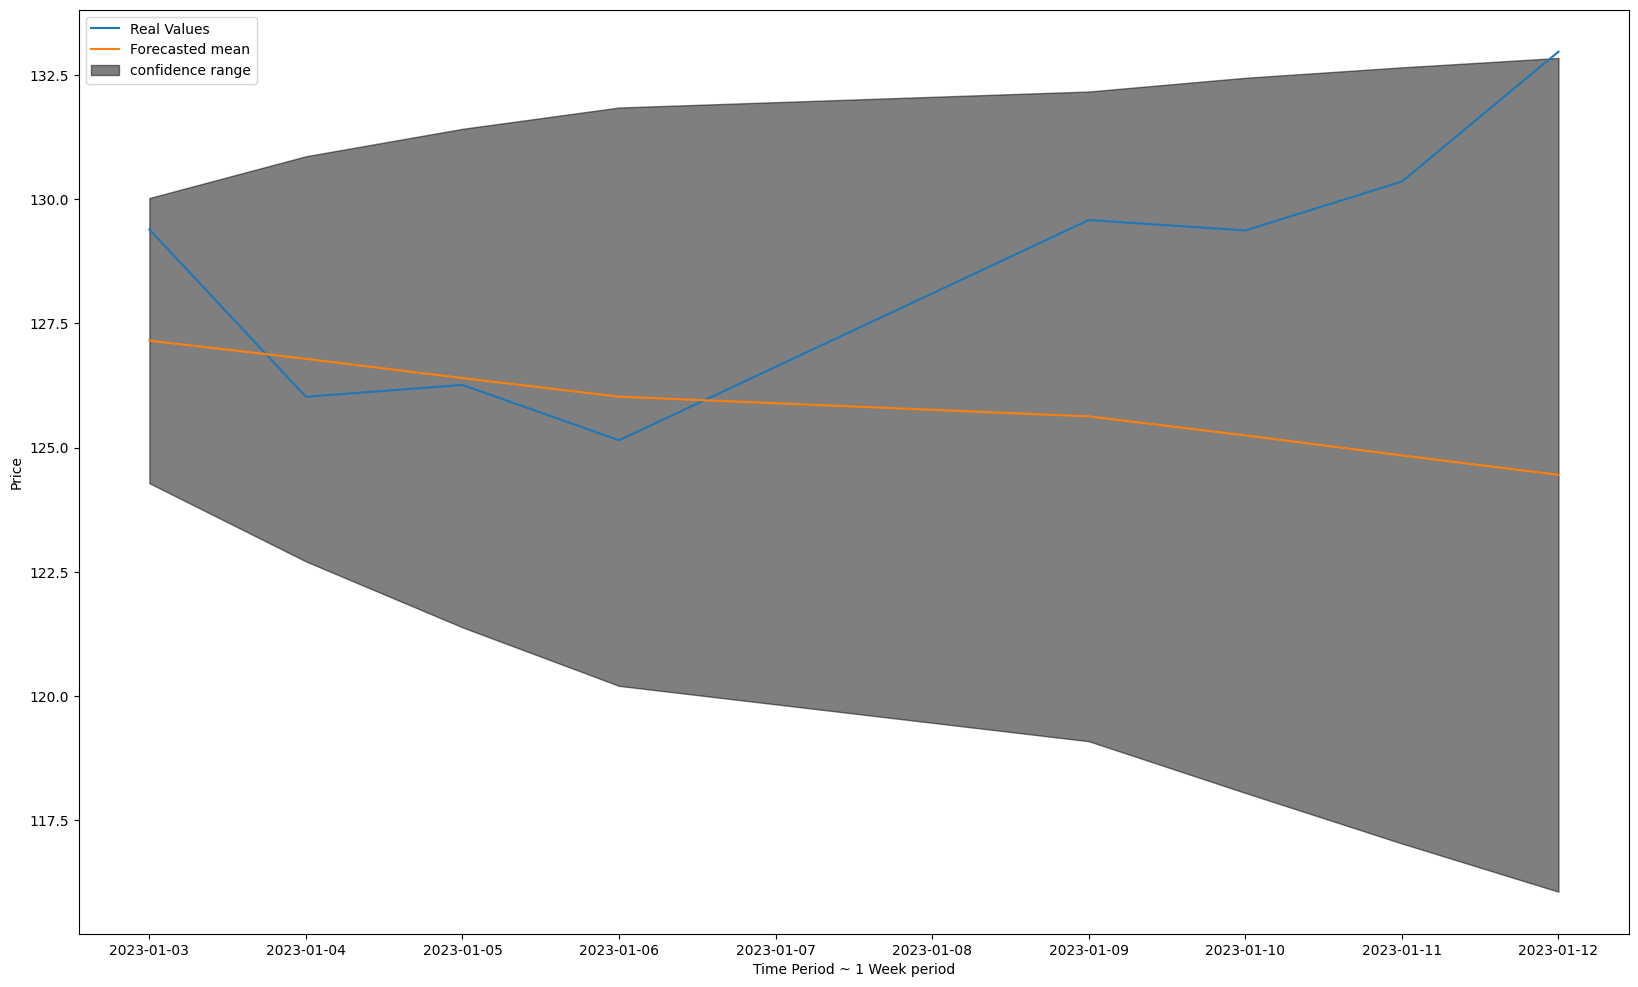

In [ ]:
fig = plt.subplots(figsize = (20,12))
plt.plot(data_test[:step].index, data_test[:step]['Open'].values, label = "Real Values")
plt.plot(forecasting.index, forecasting.values, label = 'Forecasted mean')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.5, label = 'confidence range')
plt.xlabel("Time Period ~ 1 Week period")
plt.ylabel("Price")
plt.legend()
plt.show()